# Pair Trading Strategy: Gold and Silver

In this project, we’re building a **pair trading strategy** using **gold** and **silver**. Pair trading is a *market-neutral* trading strategy that takes advantage of the historical relationship between two correlated assets.

Gold and silver tend to move together — when gold prices rise, silver prices often rise too, and when gold falls, silver usually follows. This strong correlation means that when the two prices temporarily move out of sync, there may be a trading opportunity.

Here’s the basic idea:
- We monitor the **price ratio** (or spread) between gold and silver.
- When this ratio **deviates significantly** from its historical average, we expect it to eventually **return to normal** (a concept called *mean reversion*).
- So, if gold’s price increases sharply while silver lags behind, we:
  - **Short (sell)** gold (the asset that went up),
  - **Go long (buy)** silver (the asset that went down).
- We hold these positions until the price relationship between the two reverts to its usual level, and then we close both trades for a profit.

This approach doesn’t depend on the overall market going up or down — instead, it focuses on the **relative movement** between two highly correlated assets.


In [23]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns

## Downloading and Preparing the Data

To start our analysis, we’ll need historical price data for **gold** and **silver**.  
We’ll use the **Yahoo Finance API** to easily download this data, and then use **Pandas** to organize and align it for our analysis.

Here’s the basic workflow:
1. Use the `yfinance` library to download daily price data for gold and silver (for example, using the tickers `GC=F` for gold and `SI=F` for silver).
2. Focus on the **“Close”** prices, which represent the last traded price each day.
3. Combine both datasets into a single DataFrame so that we can easily compare and analyze them side by side.
4. Make sure the dates line up correctly (Pandas will help with that automatically when we concatenate or merge by date).

Once this is done, we’ll have a clean dataset containing gold and silver prices over time — ready for analysis!


In [24]:
start_date = "2022-01-03"
today = datetime.date.today()

In [25]:
gold = yf.download("GC=F", start=start_date, end=today)
silver = yf.download("SI=F", start=start_date, end=today)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [26]:
data = pd.concat([gold['Close'],silver['Close']],axis=1)
data.columns = ["Gold_Close", "Silver_Close"]

In [27]:
data

,Gold_Close,Silver_Close
Date,,
2022-01-03,1799.400024,22.790001
2022-01-04,1814.000000,23.038000
2022-01-05,1824.599976,23.150000
2022-01-06,1788.699951,22.174000
2022-01-07,1797.000000,22.393999
...,...,...
2025-09-29,3820.899902,46.612000
2025-09-30,3840.800049,46.252998
2025-10-01,3867.500000,47.290001


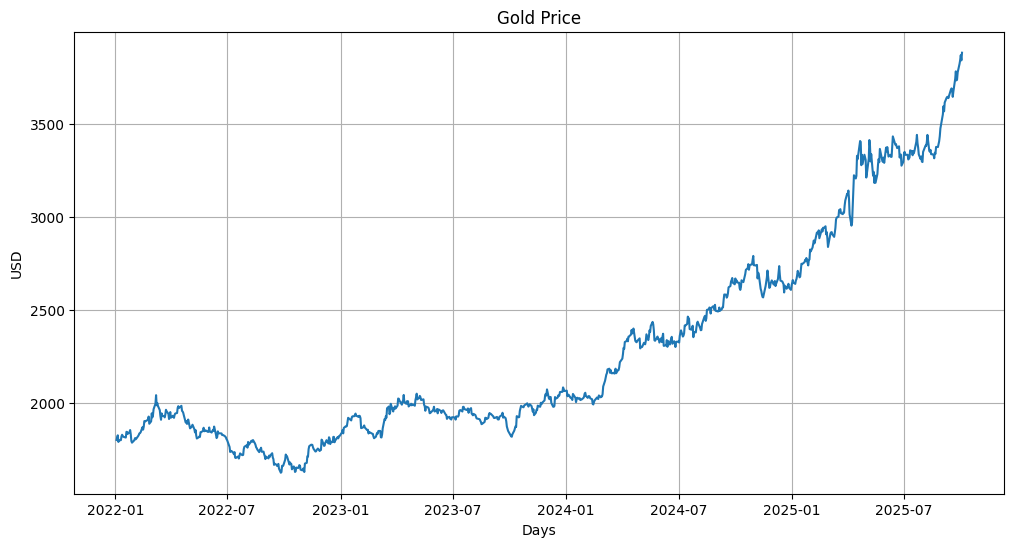

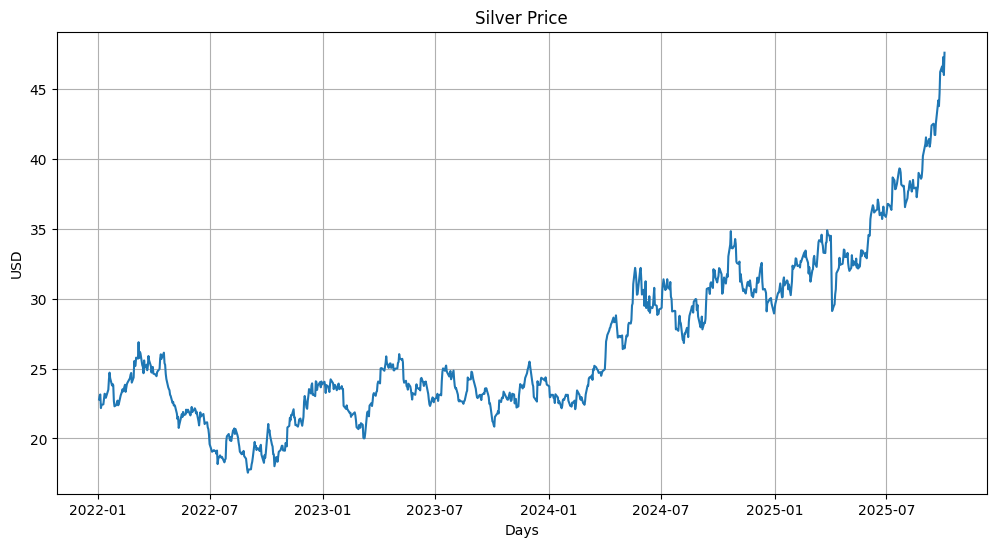

In [28]:
plt.figure(figsize=(12,6))
plt.plot(data["Gold_Close"])
plt.grid(True)
plt.title("Gold Price")
plt.xlabel("Days")
plt.ylabel("USD")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(data["Silver_Close"])
plt.grid(True)
plt.title("Silver Price")
plt.xlabel("Days")
plt.ylabel("USD")
plt.show()

## Understanding Linear Regression (and Why We Use It Here)

Next, we’ll look at how closely **gold** and **silver** prices move together, and we’ll quantify that relationship using **linear regression**.

Before running a regression, we can check their **correlation** using `.corr()` in Pandas.  
A correlation close to **+1** means the two assets move almost perfectly together — exactly what we expect for gold and silver.

After confirming a strong correlation, we’ll perform a **linear regression** using `stats.linregress` (from the `scipy.stats` module).  
This will help us **model the relationship** between gold and silver prices mathematically.

We’ll set up the regression so that:
- **Gold** is the **independent variable (X)** — the one we use to predict.
- **Silver** is the **dependent variable (Y)** — the one we’re trying to predict.

From the regression, we’ll get:
- A **slope** (how much silver’s price tends to change when gold changes by one unit),
- An **intercept** (the baseline value when gold’s price is zero),
- And some additional statistics that tell us how well the model fits.

In simple terms, this regression gives us a line of best fit describing how silver’s price typically moves relative to gold.  
Later, we’ll use this relationship to detect when silver is **overpriced or underpriced** relative to gold — the key idea behind our pair trading strategy.


In [29]:
data = data.dropna()

corr = data["Gold_Close"].corr(data["Silver_Close"])
print(f"The correlation between gold and silver is: {corr}")

The correlation between gold and silver is: 0.9617531323921918


In [30]:
slope, intercept, r_value, p_value, std_error = stats.linregress(
    data["Gold_Close"], data["Silver_Close"]
)

X = data["Gold_Close"].values.reshape(-1, 1)
y = data["Silver_Close"].values

model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [31]:
# From sklearn

print("Slope (coef_):", model.coef_[0])
print("Intercept (intercept_):", model.intercept_)
print("R^2 score:", model.score(X, y))

# From scipy

print("Slope (coef_):", slope)
print("Intercept (intercept_):", intercept)
print("R^2 score:", r_value**2)

Slope (coef_): 0.010007901781244645
Intercept (intercept_): 3.8505870420151425
R^2 score: 0.9249690876661922
Slope (coef_): 0.010007901781244633
Intercept (intercept_): 3.850587042015171
R^2 score: 0.9249690876661925


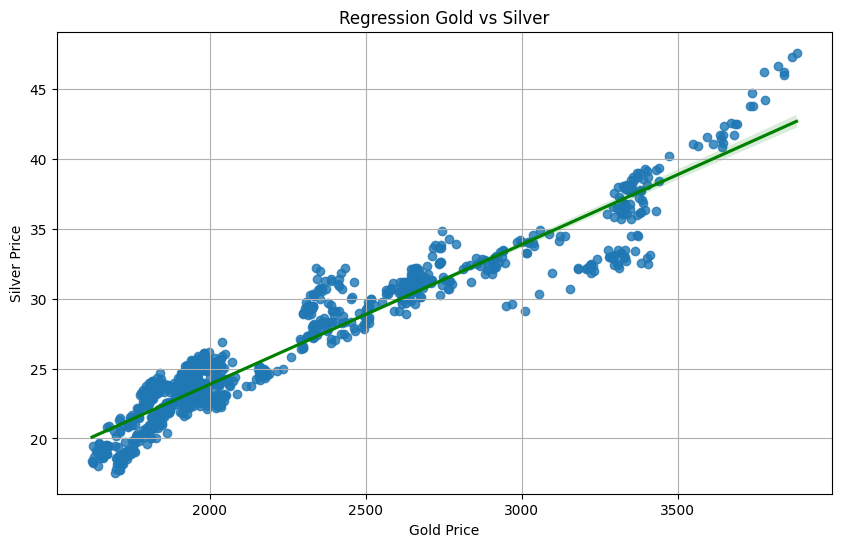

In [32]:
plt.figure(figsize=(10,6))
sns.regplot(x="Gold_Close", y="Silver_Close", data=data, line_kws={"color": "green"})
plt.title("Regression Gold vs Silver")
plt.xlabel("Gold Price")
plt.ylabel("Silver Price")
plt.grid(True)
plt.show()

## Understanding Residuals and Their Role in Pair Trading

After running our linear regression of silver on gold, we can calculate the **residuals**.  
A **residual** is simply the **difference between the actual silver price** and the **predicted silver price** based on our regression model.

Mathematically:
$$
\text{Residual} = \text{Actual Silver Price} - \text{Predicted Silver Price}
$$

These residuals tell us how far the current relationship between gold and silver is from what we’d *expect* based on their historical pattern.

### Why Residuals Matter

- If the **residual is small (close to zero)**, it means that silver’s price is roughly where our model expects it to be — gold and silver are moving together normally.
- If the **residual is large (positive or negative)**, it means the relationship has **diverged**:
  - A **large positive residual** means silver is **higher than expected** compared to gold (silver may be *overpriced*).
  - A **large negative residual** means silver is **lower than expected** compared to gold (silver may be *underpriced*).

### How This Connects to the Trading Strategy

In our pair trading setup:
- When residuals move **far from zero**, it signals a **temporary imbalance** between gold and silver prices.
- We assume that over time, this imbalance will **correct itself** (mean reversion).
- So we:
  - **Short (sell)** the asset that’s overpriced,
  - **Go long (buy)** the asset that’s underpriced,
  - And wait until the residual returns closer to zero — when we close both positions for a potential profit.

Residuals are therefore the **core trading signal** in this strategy.  
They quantify how “out of sync” the two assets are, helping us identify moments when a **reversion trade** might be profitable.


In [33]:
data['Silver_Predicted'] = slope * data['Gold_Close'] + intercept
data['Residual'] = data['Silver_Close'] - data['Silver_Predicted']

In [34]:
data.head()

,Gold_Close,Silver_Close,Silver_Predicted,Residual
Date,,,,
2022-01-03,1799.400024,22.790001,21.858806,0.931195
2022-01-04,1814.000000,23.038000,22.004921,1.033079
2022-01-05,1824.599976,23.150000,22.111004,1.038995
2022-01-06,1788.699951,22.174000,21.751720,0.422279
2022-01-07,1797.000000,22.393999,21.834787,0.559213


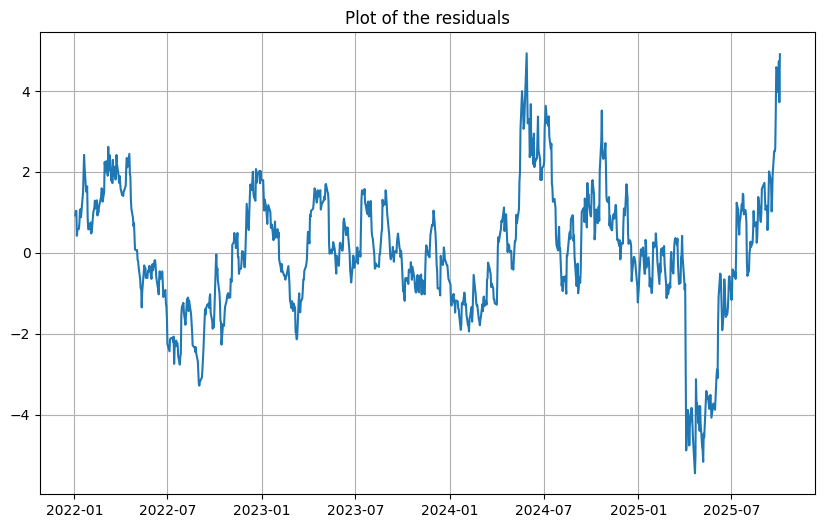

In [35]:
plt.figure(figsize=(10,6))
plt.title("Plot of the residuals")
plt.plot(data["Residual"])
plt.grid(True)
plt.show()

## Creating a Trading Signal Using Standard Deviation

Now that we’ve calculated the residuals (the difference between actual and predicted silver prices), we can use them to build a **trading signal**.

First, we need to understand **standard deviation**.

### What Is Standard Deviation?

The **standard deviation** is a statistical measure that tells us **how much a set of values varies** from its average (mean).  
- A **small standard deviation** means most values are close to the mean.  
- A **large standard deviation** means values are more spread out.

In our context, it measures **how much the residuals typically fluctuate**.  
So it gives us a sense of what’s “normal” and what’s an “unusual” deviation.

### Setting the Trading Threshold

We’ll set a **threshold** equal to **one standard deviation** of the residuals.  
This helps us identify when gold and silver prices have moved far enough apart to signal a potential trade.

### Defining the Trading Logic

- If the **residual is greater than +threshold**:
  - Silver is **more expensive than expected** (overpriced).
  - **Short silver** and **go long gold** (we expect silver to fall or gold to rise).

- If the **residual is less than –threshold**:
  - Silver is **cheaper than expected** (underpriced).
  - **Go long silver** and **short gold** (we expect silver to rise or gold to fall).

When the residual returns toward zero, it indicates that the price relationship has **normalized**, and we can **close both positions** to capture the profit from the convergence.

In short, this threshold-based rule allows us to **systematically detect and act on mean-reversion opportunities** in the gold–silver pair.


In [36]:
# Trading strategy

threshold = data["Residual"].std()

data['Signal'] = 0
data.loc[data['Residual'] > threshold, 'Signal'] = -1  # short silver, long gold
data.loc[data['Residual'] < -threshold, 'Signal'] = 1  # long silver, short gold

data

,Gold_Close,Silver_Close,Silver_Predicted,Residual,Signal
Date,,,,,
2022-01-03,1799.400024,22.790001,21.858806,0.931195,0
2022-01-04,1814.000000,23.038000,22.004921,1.033079,0
2022-01-05,1824.599976,23.150000,22.111004,1.038995,0
2022-01-06,1788.699951,22.174000,21.751720,0.422279,0
2022-01-07,1797.000000,22.393999,21.834787,0.559213,0
...,...,...,...,...,...
2025-09-29,3820.899902,46.612000,42.089778,4.522222,-1
2025-09-30,3840.800049,46.252998,42.288937,3.964062,-1
2025-10-01,3867.500000,47.290001,42.556147,4.733854,-1


## Setting Up and Executing the Trading Logic

Now that we’ve created our trading signals based on the residual thresholds, we’re going to **simulate how the strategy behaves over time**.

In this step, we’ll:
1. **Track our trading positions** — whether we’re long or short at each point in time.
2. **Enter a position** when a trading signal is triggered (when the residual moves beyond our threshold).
3. **Exit the position** when the residual crosses back through zero — meaning the spread between gold and silver has reverted to its normal relationship.
4. **Calculate daily returns** for both gold and silver.
5. **Compute the strategy’s return** based on whether we were long or short during that period.

This will allow us to see how our pair trading strategy would have performed historically, using the gold–silver spread as our trading signal.


In [37]:
total_days = len(data["Signal"])
total_signals = sum(abs(s) for s in data["Signal"])
pct_signals = total_signals / total_days
print(f"Signal present {pct_signals*100}% of the times")

Signal present 24.89406779661017% of the times


In [38]:
data['Position'] = 0
position = 0

for i in range(1, len(data)):
    if data["Signal"].iloc[i] != 0:
        position = data["Signal"].iloc[i]
    elif position != 0 and np.sign(data['Residual'].iloc[i-1]) != np.sign(data['Residual'].iloc[i]):
        """Exit position if the residuals change sign"""
        position = 0  # exit
    data.iloc[i, data.columns.get_loc('Position')] = position


In [39]:
data.head()

,Gold_Close,Silver_Close,Silver_Predicted,Residual,Signal,Position
Date,,,,,,
2022-01-03,1799.400024,22.790001,21.858806,0.931195,0,0
2022-01-04,1814.000000,23.038000,22.004921,1.033079,0,0
2022-01-05,1824.599976,23.150000,22.111004,1.038995,0,0
2022-01-06,1788.699951,22.174000,21.751720,0.422279,0,0
2022-01-07,1797.000000,22.393999,21.834787,0.559213,0,0


In [40]:
data['Silver_Return'] = data['Silver_Close'].pct_change()
data['Gold_Return'] = data['Gold_Close'].pct_change()
data.head()

,Gold_Close,Silver_Close,Silver_Predicted,Residual,Signal,Position,Silver_Return,Gold_Return
Date,,,,,,,,
2022-01-03,1799.400024,22.790001,21.858806,0.931195,0,0,NaN,NaN
2022-01-04,1814.000000,23.038000,22.004921,1.033079,0,0,0.010882,0.008114
2022-01-05,1824.599976,23.150000,22.111004,1.038995,0,0,0.004862,0.005843
2022-01-06,1788.699951,22.174000,21.751720,0.422279,0,0,-0.042160,-0.019676
2022-01-07,1797.000000,22.393999,21.834787,0.559213,0,0,0.009921,0.004640


In [41]:
# This strategy assumes we buy the same amount of silver and gold

data['Strategy_Return'] = data['Position'].shift(1) * (data['Silver_Return'] - data['Gold_Return'])

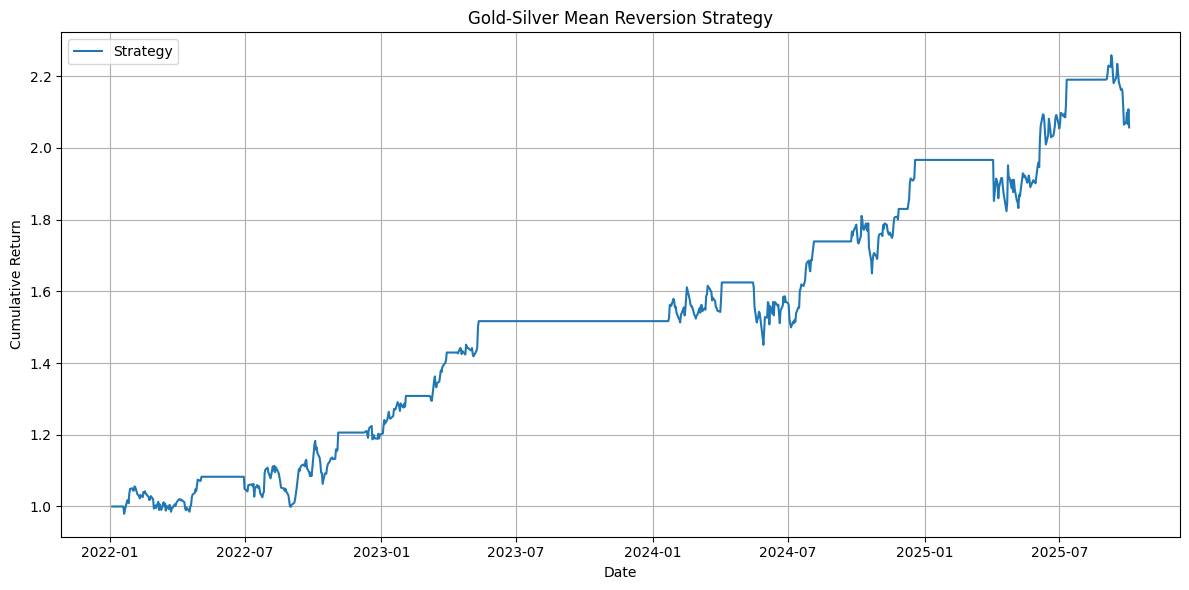

In [42]:
data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Return'], label='Strategy')
plt.title("Gold-Silver Mean Reversion Strategy")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from utils.portfolio_evaluation import sharpe_ratio

In [44]:
returns = data['Strategy_Return'].dropna().to_numpy()
rf_daily = 0.04 / 252
sharpe = sharpe_ratio(returns, dt=252, rf=rf_daily)
print(f"The Sharpe Ratio of our strategy is: {sharpe}")

The Sharpe Ratio of our strategy is: 1.015360127824674


## Limitations of the Current Implementation

Before we move forward, let’s quickly acknowledge a few key limitations of our current demo:
- We used a **single linear regression** across the entire dataset, which introduces **look-ahead bias** — in reality, we can’t use future data to inform past trades.  
- We **assumed equal weighting** between gold and silver, ignoring differences in volatility, price scale, and contract size.  
- We **ignored transaction costs, slippage, and execution delays**, which can significantly affect real performance.  
- Our model used **daily data**, but in practice, markets move much faster — sometimes by the second.

Now, it’s time to take this simple model and make it real.

---

## Next Steps by Branch (Quantitative Trading Initiative)

This notebook served as a foundation for understanding the gold–silver pair trading concept.  
From here, each branch of the **Quantitative Trading Initiative (QTI)** within the **Machine Learning Society** will specialize in turning this demo into a real, robust trading system.

---

### 🧠 Research Branch
- Implement **rolling or expanding regressions** to eliminate look-ahead bias.  
- Experiment with **z-score normalization** for residuals to make signals more consistent.  
- Test the strategy on **other correlated pairs** (e.g., oil–gas, Apple–Microsoft, ETFs).  
- Optimize **lookback windows** and **entry/exit thresholds**.  
- Use the **hedge ratio** (regression slope) for proper position sizing instead of equal weighting.

**Goal:** Build statistically sound and generalizable models.

---

### ⚙️ Execution Branch
- Develop a **live trading pipeline** using the **Interactive Brokers (IBKR) API**.  
- Automate the process of sending buy/sell/exit orders based on live signals.  
- Simulate **latency, slippage, and order execution** to test real-world behavior.  
- Build a **real-time dashboard** to visualize trades and open positions.

**Goal:** Make the strategy tradeable in real markets with reliable execution.

---

### 📉 Risk Branch
- Compute and monitor **key performance metrics**:
  - Cumulative return  
  - Sharpe ratio  
  - Maximum drawdown  
  - Win/loss ratio  
  - Standard deviation of returns  
- Estimate **risk of ruin** and use the **Kelly Criterion** for position sizing.  
- Conduct **stress tests** for extreme market conditions (e.g., 2008, 2020).

**Goal:** Ensure the strategy remains profitable, stable, and resilient under uncertainty.

---

### 🧩 Data Branch
- Build **real-time data pipelines** for gold, silver, and other assets using APIs (e.g., Yahoo Finance, IBKR).  
- Enable **continuous data flow** for live signal generation.  
- Experiment with **different time frequencies** — daily, hourly, minute-by-minute, or second-level.  
- Maintain **data integrity**: synchronization, cleaning, and storage.  
- Support all branches with a robust **backtesting environment**.

**Goal:** Deliver clean, reliable, and real-time data infrastructure.

---

## 🧭 Call to Action

This project has shown how a simple statistical idea can evolve into a powerful quantitative trading strategy.  
Now it’s up to you — the members of the **Quantitative Trading Initiative** — to push it forward.

Each branch has a unique role, but success depends on collaboration.  
Together, **Research**, **Execution**, **Risk**, and **Data** will turn this demo into a **fully operational, live trading system** that embodies the principles of machine learning, quantitative analysis, and disciplined financial engineering.

Let’s build something real.
